## Import Libraries 

In [2]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from typing import Tuple

## Random seeds for reproducibility

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Load and Preprocess Data 

In [4]:
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].astype(float)
    data = data.sort_values(by='Date').reset_index(drop=True)
    return data

## Scale Data

In [5]:
def scale_data(prices: pd.DataFrame) -> Tuple[np.ndarray, MinMaxScaler]:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(prices)
    return scaled_data, scaler

## Create Dataset 

In [6]:
def create_dataset(data: np.ndarray, time_step: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

## Build Model 

In [7]:
def build_lstm_model(time_step: int) -> Sequential:
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Forecast prices 

In [8]:
def forecast_prices(model: Sequential, data: np.ndarray, time_step: int, forecast_days: int, scaler: MinMaxScaler) -> np.ndarray:
    temp_input = data[-time_step:].reshape(1, time_step, 1)
    lst_output = []
    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        temp_input = np.append(temp_input[:, 1:, :], predicted_price[:, np.newaxis, :], axis=1)
        lst_output.append(predicted_price.tolist())
    lst_output = np.array(lst_output)
    lst_output = lst_output.reshape(lst_output.shape[0], lst_output.shape[1])
    return scaler.inverse_transform(lst_output)

## Visualization

In [9]:
def plot_results(data: pd.DataFrame, train_data: pd.DataFrame, test_data: pd.DataFrame, predictions: pd.DataFrame, 
                 forecast_30: np.ndarray, forecast_60: np.ndarray, forecast_90: np.ndarray, name_model) -> None:
    forecast_start_date = data['Date'].iloc[-1] + pd.Timedelta(days=1)
    forecast_30_dates = pd.date_range(start=forecast_start_date, periods=30, freq='D')
    forecast_60_dates = pd.date_range(start=forecast_start_date, periods=60, freq='D')
    forecast_90_dates = pd.date_range(start=forecast_start_date, periods=90, freq='D')

    plt.figure(figsize=(12, 6))
    plt.plot(train_data['Date'], train_data['Price'], label='Train Price')
    plt.plot(test_data['Date'], test_data['Price'], label='Test Price')
    plt.plot(predictions['Date'], predictions['Price'], label='Predicted Price on Test Data')
    plt.plot(forecast_30_dates, forecast_30, label='30 Day Forecast', zorder=3)
    plt.plot(forecast_60_dates, forecast_60, label='60 Day Forecast', zorder=2)
    plt.plot(forecast_90_dates, forecast_90, label='90 Day Forecast', zorder=1)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(name_model)
    plt.legend()
    plt.show()


## Model evaluation

In [10]:
def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"MSE: {mse:.6f}")

## File Path of BNB Data 

In [11]:
file_path = 'BNB Historical Data.csv'
data = load_and_preprocess_data(file_path)
prices = data[['Price']]

## 1. BNB Data with 7/3 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1051
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
E

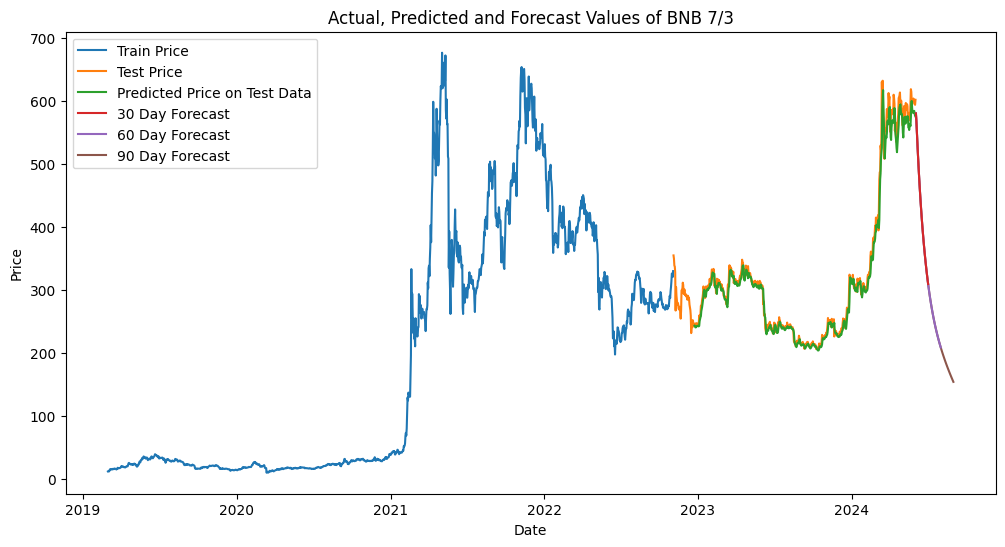

In [12]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.7)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
# Plot results including test data and predictions
name_model = 'Actual, Predicted and Forecast Values of BNB 7/3'
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## 2. BNB Data with 8/2 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0838
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
E

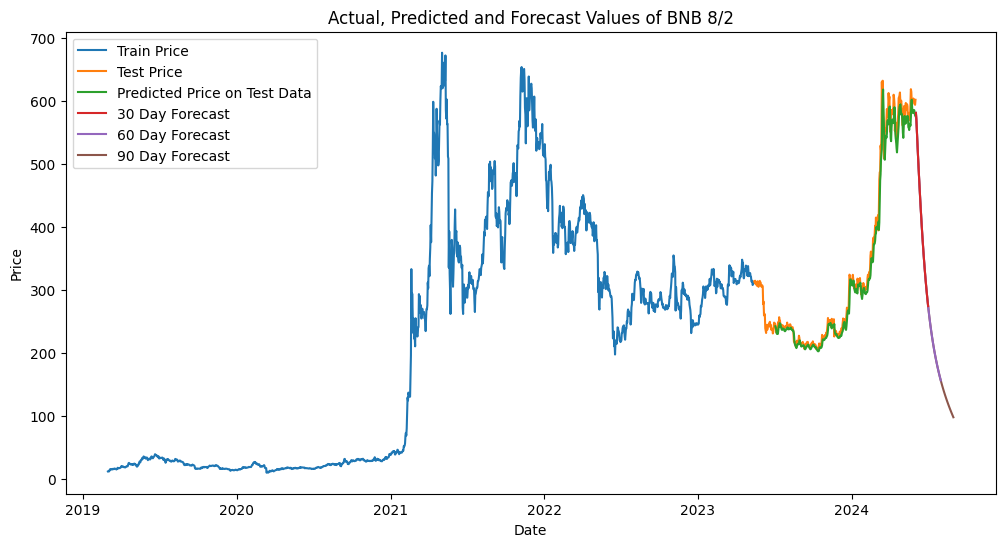

In [13]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.8)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
name_model = 'Actual, Predicted and Forecast Values of BNB 8/2'
# Plot results including test data and predictions
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## 3. BNB Data with 9/1 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0432
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8998e-04
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.6497e-04
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 

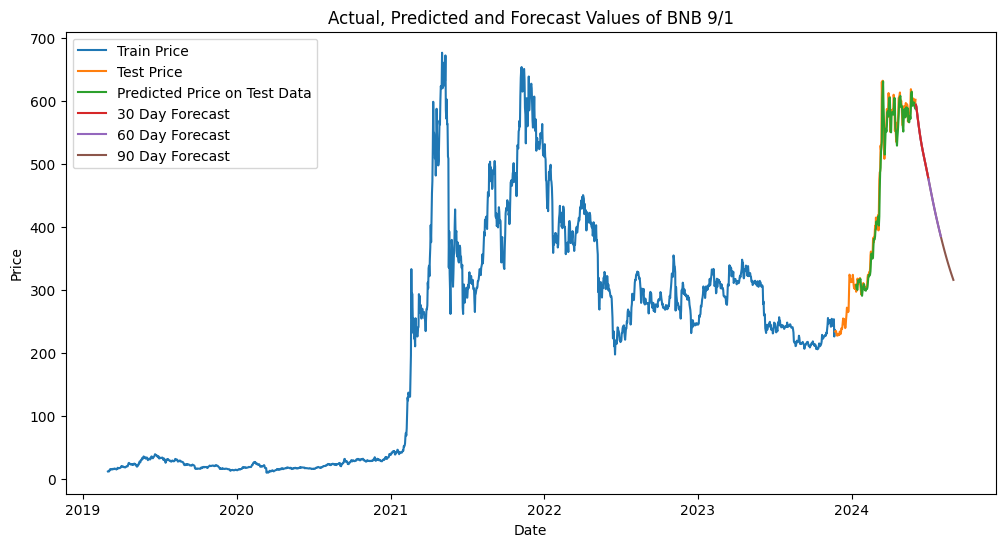

In [14]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.9)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
name_model = 'Actual, Predicted and Forecast Values of BNB 9/1'
# Plot results including test data and predictions
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## File Path of Dogecoin Data 

In [15]:
file_path = 'Dogecoin Historical Data.csv'
data = load_and_preprocess_data(file_path)
prices = data[['Price']]

## 4. Dogecoin Data with 7/3 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0342
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011  
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011

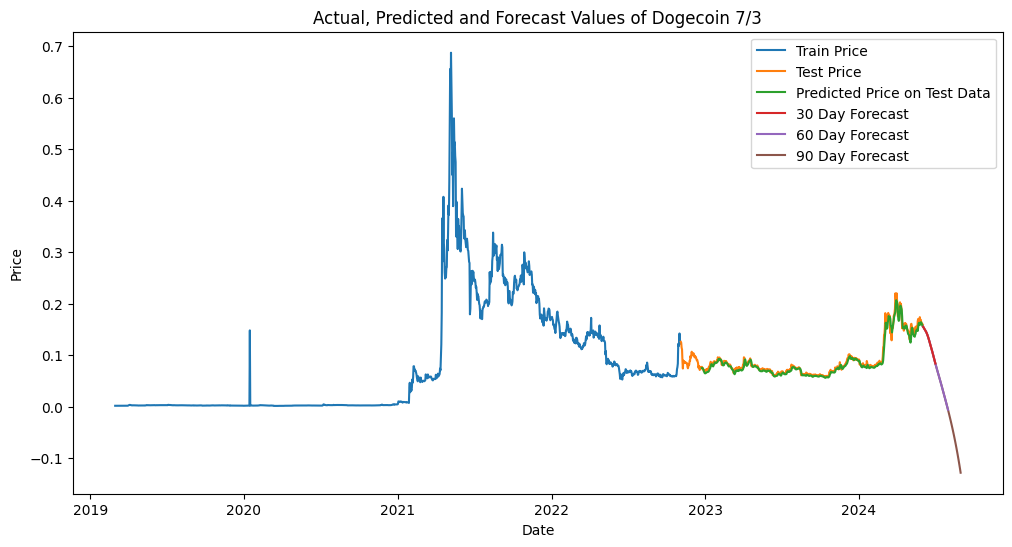

In [16]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.7)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
# Plot results including test data and predictions
name_model = 'Actual, Predicted and Forecast Values of Dogecoin 7/3'
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## 5. Dogecoin Data with 8/2 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0187
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9175e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.5968e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2954e-04
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0105e-04
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7420e-04
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

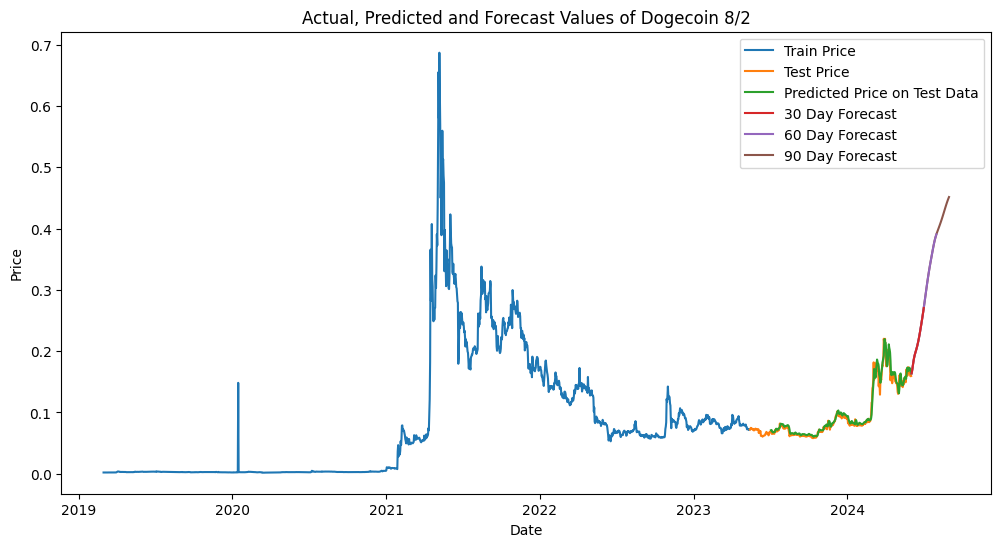

In [17]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.8)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
# Plot results including test data and predictions
name_model = 'Actual, Predicted and Forecast Values of Dogecoin 8/2'
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## 6. Dogecoin Data with 9/1 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0169
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010  
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.1271e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4591e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.0317e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7381e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4833e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2443e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0157e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7963e-04
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5853e-04
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3819e-04
Epoch 15/100
27/27 ━━━━━━━━

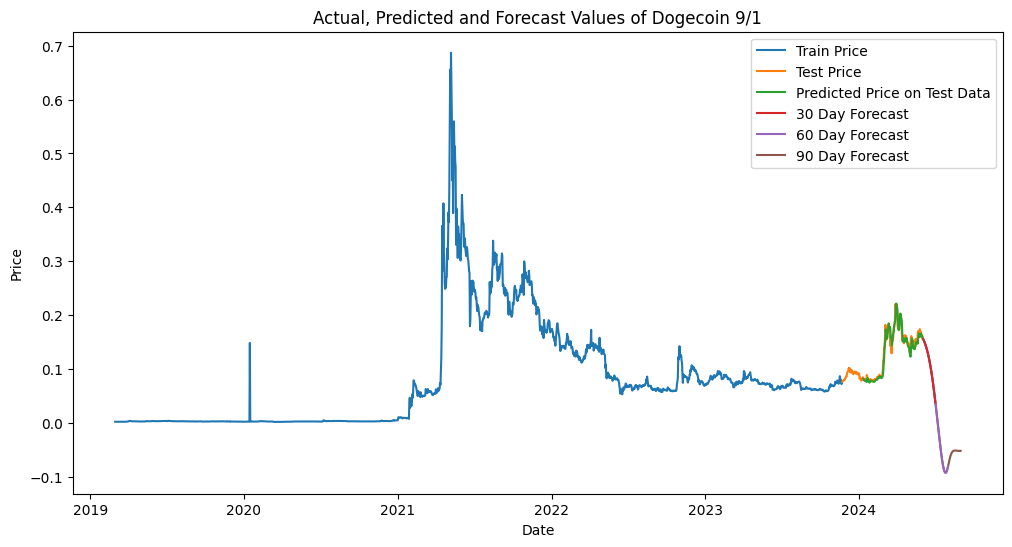

In [18]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.9)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
# Plot results including test data and predictions
name_model = 'Actual, Predicted and Forecast Values of Dogecoin 9/1'
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## File Path of TRON Data

In [19]:
file_path = 'TRON Historical Data.csv'
data = load_and_preprocess_data(file_path)
prices = data[['Price']]

## 7. TRON Data with 7/3 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0694
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
E

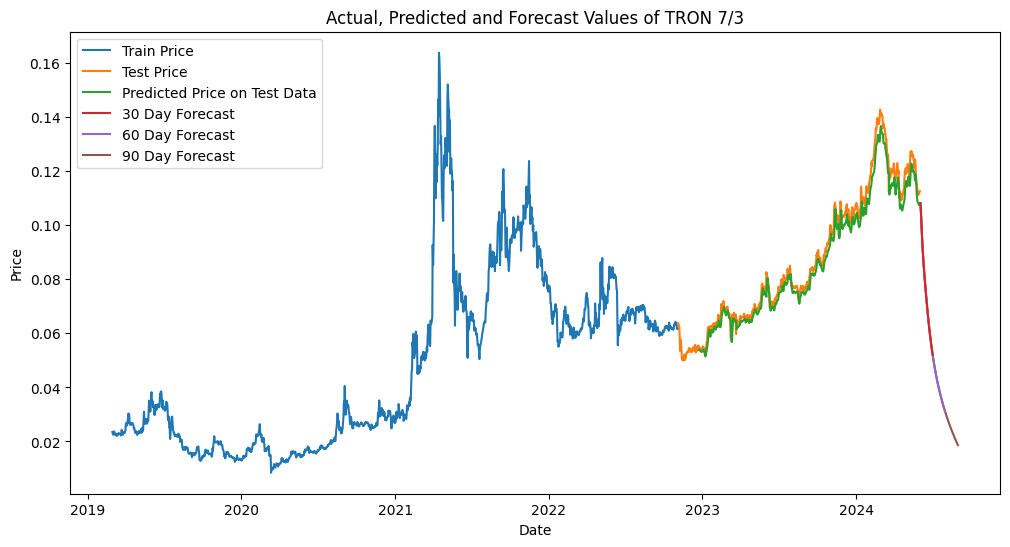

In [20]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.7)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
# Plot results including test data and predictions
name_model = 'Actual, Predicted and Forecast Values of TRON 7/3'
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## 8. TRON Data with 8/2 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0369
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010  
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010    
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.6876e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3774e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.1176e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8964e-04
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7026e-04
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.5265e-04
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━

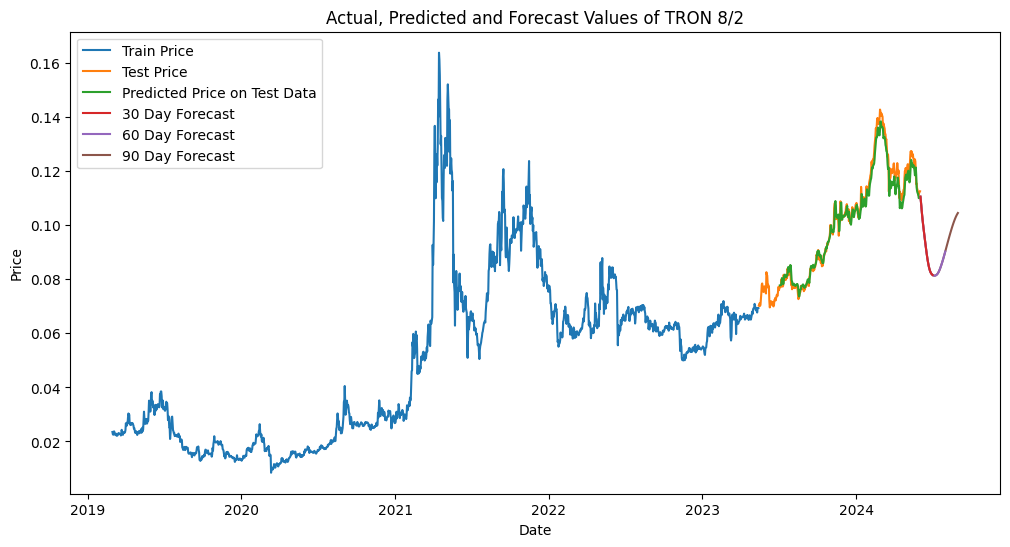

In [21]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.8)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
# Plot results including test data and predictions
name_model = 'Actual, Predicted and Forecast Values of TRON 8/2'
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)

## 9. TRON Data with 9/1 split 

Epoch 1/100


C:\Users\thevi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0541
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010  

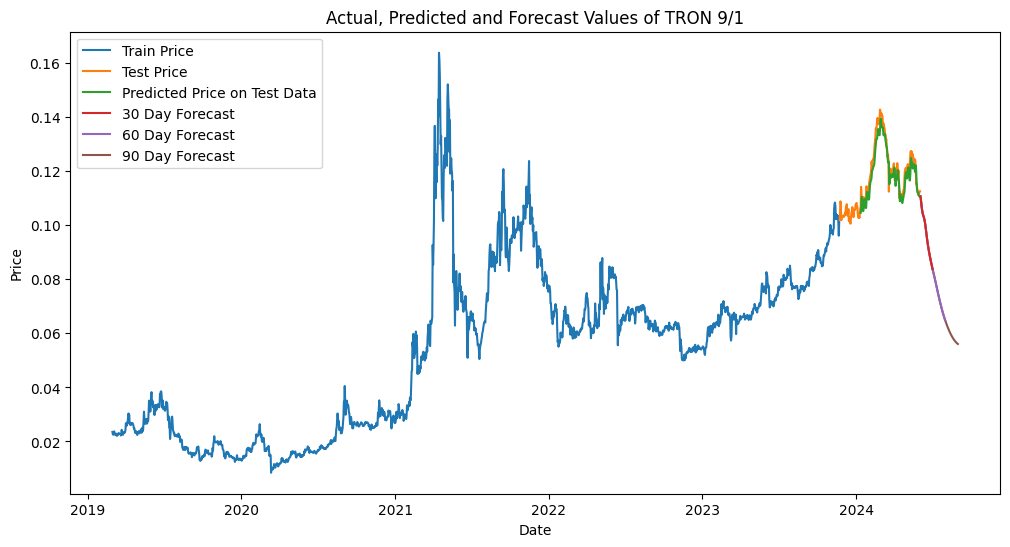

In [22]:
# Split data before scaling to avoid data leakage
train_size = int(len(prices) * 0.9)
train_prices, test_prices = prices[:train_size], prices[train_size:]

scaled_train_data, scaler = scale_data(train_prices)
scaled_test_data = scaler.transform(test_prices)

time_step = 50
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = build_lstm_model(time_step)

model.fit(X_train, y_train, batch_size=64, epochs=100)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
calculate_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

forecast_30 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 30, scaler)
forecast_60 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 60, scaler)
forecast_90 = forecast_prices(model, scaled_test_data[-time_step:], time_step, 90, scaler)

# Correct the indices for the test data to ensure continuous plot
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Create a DataFrame for predictions with the same dates as test_data
predicted_dates = test_data.iloc[time_step:len(predictions) + time_step].reset_index(drop=True)
predictions_df = pd.DataFrame(data=predictions, columns=['Price'])
predictions_df['Date'] = predicted_dates['Date']
# Plot results including test data and predictions
name_model = 'Actual, Predicted and Forecast Values of TRON 9/1'
plot_results(data, train_data, test_data, predictions_df, forecast_30, forecast_60, forecast_90, name_model)